In [0]:
import tensorflow as tf
import gzip
import os
import sys
import shutil
import numpy as np

!pip install spectral
import spectral

!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from six.moves import urllib
from tensorflow import keras
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
from tensorflow.contrib.tensorboard.plugins import projector
#from google.colab import files
from skimage import io
from matplotlib import pyplot as plt
from decimal import Decimal
from sklearn.cluster import KMeans

if not os.path.exists('./ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

plt.rcParams["axes.grid"] = False

In [0]:
# Set up different folders for different runs of the model
!rm -r sample_data
!rm -r './models'

models_folder = './models'
model_number = 0

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

rm: cannot remove './models': No such file or directory


In [0]:
# TENSORBOARD LINK
LOG_DIR = models_folder
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://59e0fb81.ngrok.io


In [0]:
# UPLOAD TRAIN AND TEST TFRECORDS (only if needed)
#uploaded = files.upload()

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Dataset drive ids and local filenames
train_drive_id = '1ZjiUZoB8vRPQWr-G6ORZooRx4qC4-ME8'
test_drive_id = '13Mv43bwnzwxMYKfoRRFKcy38IKyueWCR'
train_file = "Train.tfrecord"
test_file = "Test.tfrecord"

# Download files to local machine from drive
train_download = drive.CreateFile({'id': train_drive_id})
train_download.GetContentFile(train_file)
test_download = drive.CreateFile({'id': test_drive_id})
test_download.GetContentFile(test_file)

# PARAMS

In [0]:
# PARAMS (hyperparameters)

# General params
batch_size = 50
eval_batch_size = 50
num_epochs = 25
random_batches = 4
image_size = 256
learning_rate = 1e-4

# Technical params
conv_layers = [10, 10, 20, 20] # convolutional kernels (first layer has this many kernels, second layer has double this number)
kernel_sizes = [16, 12, 8, 6] # size of the convolution filters
embedding_size = 24 # number of output features
dropout_rate = 0.4
padding = 'valid'

use_batch_norm = True # batch normalization?
squared = False # euclidean distance norm squared?

margin = 1.0 # margin distance between (a,p) and (a,n)
triplet_strategy = 'batch_all_semihard_tf' # 'batch_all' (blog implementation not working?) - 'batch_all_semihard_tf' (tensorflow semihard batch all) - 'batch_hard' (batch hard blog implementation)

# Save checkpoints during training params
save_summary_steps = save_checkpoints_steps = 100
min_secs_eval = 1.0

# Early stopping param
max_steps_without_decrease = 800
run_every_steps = save_checkpoints_steps # Run validation every ? steps

# Triplet loss params
label_frames_tolerance = 4

# Features when reading Examples
features = {
    'rows': tf.FixedLenFeature([], tf.int64),
    'cols': tf.FixedLenFeature([], tf.int64),
    'channels': tf.FixedLenFeature([], tf.int64),
    'image': tf.FixedLenFeature([], tf.string),
    'label': tf.FixedLenFeature([], tf.int64)
}

# TFRECORD EXTRACTOR

In [0]:
# CLASS TO EXTRACT IMAGES FROM A TFRECORD AND RETURN IN A DATASET
class TFRecordExtractor:
    def __init__(self, tfrecord_file):
        self.tfrecord_file = os.path.abspath(tfrecord_file)

    def _extract_fn(self, tfrecord):
        # Extract the data record
        sample = tf.parse_single_example(tfrecord, features)

        # cast image [0, 255] to [0.0, 1.0]
        image = tf.image.decode_image(sample['image'], dtype=tf.uint8)
        image = tf.cast(image, tf.float32)
        image = image / 255
        img_shape = tf.stack([sample['rows'], sample['cols'], sample['channels']])
        label = sample['label']
        label = tf.cast(label, tf.int64)
        #filename = sample['filename']
        
        return image, label

    def extract_image(self):

        # Pipeline of dataset
        dataset = tf.data.TFRecordDataset([self.tfrecord_file])
        dataset = dataset.map(self._extract_fn)
        
        return dataset

# LOSSES AND SUPPORT FUNCTIONS

In [0]:
"""Define functions to create the triplet loss with online triplet mining."""

def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.
    output[i, j] = || feature[i, :] - feature[j, :] ||_2
    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.
    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
          pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = pairwise_distances(embeddings, squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.cast(mask_anchor_positive, tf.float32)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.cast(mask_anchor_negative, tf.float32)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.
    Args:
    data: 2-D float `Tensor` of size [n, m].
    mask: 2-D Boolean `Tensor` of size [n, m].
    dim: The dimension over which to compute the minimum.
    Returns:
    masked_minimums: N-D `Tensor`.
      The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
      math_ops.multiply(data - axis_maximums, mask), dim,
      keepdims=True) + axis_maximums
    return masked_minimums

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.
    Args:
    data: 2-D float `Tensor` of size [n, m].
    mask: 2-D Boolean `Tensor` of size [n, m].
    dim: The dimension over which to compute the maximum.
    Returns:
    masked_maximums: N-D `Tensor`.
      The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
      math_ops.multiply(data - axis_minimums, mask), dim,
      keepdims=True) + axis_minimums
    return masked_maximums

def triplet_semihard_loss(labels, embeddings, margin=1.0):
    
    """Computes the triplet loss with semi-hard negative mining.
    The loss encourages the positive distances (between a pair of embeddings with
    the same labels) to be smaller than the minimum negative distance among
    which are at least greater than the positive distance plus the margin constant
    (called semi-hard negative) in the mini-batch. If no such negative exists,
    uses the largest negative distance instead.
    See: https://arxiv.org/abs/1503.03832.
    Args:
    labels: 1-D tf.int32 `Tensor` with shape [batch_size] of
      multiclass integer labels.
    embeddings: 2-D float `Tensor` of embedding vectors. Embeddings should
      be l2 normalized.
    margin: Float, margin term in the loss definition.
    Returns:
    triplet_loss: tf.float32 scalar.
    """
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    lshape = array_ops.shape(labels)
    assert lshape.shape == 1
    labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=squared)
    
    
    # Build pairwise binary adjacency matrix.
    #adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    abs_label_distances = tf.cast(math_ops.abs(pairwise_distance( tf.cast(labels, tf.float32) )), tf.int64)
    adjacency = math_ops.less(abs_label_distances, label_frames_tolerance)
    
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    batch_size = array_ops.size(labels)

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
      array_ops.tile(adjacency_not, [batch_size, 1]),
      math_ops.greater(
          pdist_matrix_tile, array_ops.reshape(
              array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
      math_ops.greater(
          math_ops.reduce_sum(
              math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
          0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
      masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
      masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
      mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
      adjacency, dtype=dtypes.float32) - array_ops.diag(
          array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    triplet_loss = math_ops.truediv(
      math_ops.reduce_sum(
          math_ops.maximum(
              math_ops.multiply(loss_mat, mask_positives), 0.0)),
      num_positives,
      name='triplet_semihard_loss')

    return triplet_loss, num_positives/( tf.cast(batch_size, tf.float32) )

# KNN SCORE DEFINITIONS

In [0]:
def KNN(emb_dist, emb_index):
    row = emb_dist[emb_index, :]
    result = tf.nn.top_k(row, k=row.shape[0])
    return tf.Session().run(result[0]), tf.Session().run(result[1])

def show_KNN(images_set, emb_dist, i, rows, columns, figsize=25):
    all_labels = images_set[:,1]
    find, = np.where(all_labels == i)
    most_k_similar = least_k_similar = rows*columns
    
    if len(find) <= 0:
        print('Label selected is not in the test set!')
        return
    elif len(find) > 1:
        print('More than 1 image found in the test set with the same label!')
        return
    
    i = find[0]
    distances, index = KNN(emb_dist, i)

    similar_index = index[-most_k_similar-1:-1]
    similar_dist = distances[-most_k_similar-1:-1]
    similar_index, similar_dist = np.flip(similar_index, 0), np.flip(similar_dist, 0)

    least_index = index[:least_k_similar]
    least_dist = distances[:least_k_similar]
    
    # SHOW MAIN IMAGE
    f, axarr = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
    img, label = images_set[i]
    axarr.imshow(img)
    axarr.set_title('Label: {}'.format(label), fontsize=20)
    plt.show()
    
    # SHOW K SIMILAR IMAGES
    print('\nThe',most_k_similar,'most similar images:')
    f, axarr = plt.subplots(ncols=columns, nrows=rows, figsize=(figsize, int(figsize/2)))
    col = 0
    row = 0
    for j, dist in zip(similar_index, similar_dist):
        img, label = images_set[j]
        axarr[row, col].imshow(img)
        axarr[row, col].set_title('L: {} - D: {:.4f}'.format(label, dist), fontsize=12)
        col += 1
        if col%columns==0:
            row += 1
            col = 0
    plt.show()
    
    # SHOW K MOST DIFFERENT IMAGES
    print('\nThe',least_k_similar,'least similar images:')
    f, axarr = plt.subplots(ncols=columns, nrows=rows, figsize=(figsize, int(figsize/2)))
    col = 0
    row = 0
    for j, dist in zip(least_index, least_dist):
        img, label = images_set[j]
        axarr[row, col].imshow(img)
        axarr[row, col].set_title('L: {} - D: {:.4f}'.format(label, dist), fontsize=12)
        col += 1
        if col%columns==0:
            row += 1
            col = 0
    plt.show()

In [0]:
def simple_KNN_score(emb_dist, all_labels=None, images_set=None, fracc=0.1):
    print("Score based on the",2*label_frames_tolerance,"most similar frames for a given frame")
    
    if fracc > 1.0: fracc = 1.0
    if fracc <= 0.0: return 0, 0
    if images_set is None and all_labels is None:
        print("Cannot get the labels list")
        return
    if all_labels is None:
        all_labels = images_set[:,1]
    
    num_elements = int(fracc*len(all_labels))
    num_elements = num_elements if num_elements > 0 else 1
    
    #print("num_elements:",num_elements)
    
    step = int(len(all_labels) / num_elements)
    
    sum_score = 0
    sum_dist = 0
    for i in range(num_elements):
        j = (i+1)*step
        if j >= len(all_labels): break
        
        label = all_labels[j]
        #if label < label_frames_tolerance or label > len(all_labels) - label_frames_tolerance: continue
        
        find, = np.where(all_labels == label)
        if len(find) <= 0:
            print('Label selected is not in the test set!')
            continue
        elif len(find) > 1:
            print('More than 1 image found in the test set with the same label!')
            continue
        
        j = find[0]
        
        distances = emb_dist[j, :]
        index = np.argsort(distances)

        similar_index = index[1:2*label_frames_tolerance + 1]
        similar_labels = [all_labels[k] for k in similar_index]
        positives = np.abs(similar_labels-label) < label_frames_tolerance
        
        sum_score += np.sum(positives)
        sum_dist += np.sum( distances[similar_index] )
        #print(np.sum(similar_dist) / (2*label_frames_tolerance))
        #print(np.sum(positives))
        #print(label)
        #if i%50==0: print(i)
        
    return sum_score / (num_elements*2*label_frames_tolerance), sum_dist / (num_elements*2*label_frames_tolerance)

In [0]:
def tf_simple_KNN_score(embeddings, all_labels, is_training):
    #print("Score based on the",2*label_frames_tolerance,"most similar frames for a given frame")
    
    if is_training: return (tf.constant(0.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32))
    
    emb_dist = pairwise_distance(tf.math.l2_normalize(embeddings, axis=1), squared=squared)
    
    def index_to_label(index):
        return tf.cond(tf.less(tf.cast(index, tf.int32), tf.cast(array_ops.size(all_labels), tf.int32) ), lambda: all_labels[index], lambda: all_labels[-1] ) 
    
    def compute_label_values(row_distance, batch_size, label):
        distances = tf.reshape(row_distance, [array_ops.size(row_distance)])
        
        index = tf.argsort(distances)
        distances = tf.sort(distances)[1:2*label_frames_tolerance + 1]

        similar_index = index[1:2*label_frames_tolerance + 1]
        
        similar_labels = tf.cast(tf.map_fn(index_to_label, similar_index, dtype=tf.int64), tf.int64)
        positives = math_ops.less(math_ops.abs(math_ops.subtract(similar_labels, label )) , label_frames_tolerance)
        
        score = tf.reduce_sum( tf.cast(positives, tf.float32) )
        dist = tf.reduce_sum( tf.cast(distances, tf.float32) )
        
        return score, dist
    
    def label_in_range(emb_dist, j, batch_size, label):
        #return tf.cast(tf.shape(emb_dist)[0], tf.float32), tf.cast(tf.shape(emb_dist)[1], tf.float32)
        j = tf.cast(j, tf.int32)
        row_distance = tf.cond( tf.logical_and( tf.equal(batch_size, tf.cast(array_ops.shape(emb_dist)[1], tf.int64)), tf.less(j, tf.cast(tf.shape(emb_dist)[0], tf.int32) ) ), lambda: tf.slice(emb_dist, [j, 0], [1, tf.cast(tf.shape(emb_dist)[1],tf.int32)] ), lambda: tf.constant(np.empty(0), dtype=tf.float32) ) 
        return tf.cond(tf.equal(tf.size(row_distance), 0), lambda: (tf.constant(0.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32)) , lambda: compute_label_values(row_distance, batch_size, label))
    
    def compute_label(label):
        
        find = tf.where(tf.equal(all_labels, label))
        j = find[0][0]
        
        batch_size = tf.cast(array_ops.shape(all_labels), tf.int64)[0]
        #if batch_size: return tf.constant(0.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32)
        
        return tf.cond( tf.less(tf.cast(j, tf.int32), tf.shape(emb_dist)[0]), lambda: label_in_range(emb_dist, j, batch_size, label), lambda: (tf.constant(0.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32)) )

        
    #return tf.map_fn(compute_label, all_labels, dtype=(tf.float32, tf.float32))
    
    reduced_labels = tf.slice(all_labels, [tf.cast((tf.size(all_labels) / 2), tf.int32)], [1] )
    sums = compute_label(reduced_labels)
    #sums = tf.map_fn(compute_label, reduced_labels, dtype=(tf.float32, tf.float32))
    score_mean = math_ops.truediv(math_ops.reduce_mean(sums[0]), tf.cast(2*label_frames_tolerance,tf.float32) , name='KNN_mean_score')
    distance_mean = math_ops.truediv(math_ops.reduce_mean(sums[1]), tf.cast(2*label_frames_tolerance,tf.float32) , name="KNN_mean_distance")
    
    return score_mean, distance_mean

# RANK SCORE DEFINITIONS

In [0]:
def rank_n_single_score(positives, n):
    rank_range = positives[:n]
    return 1 if np.sum(rank_range) > 0 else 0

def rank_n_score(emb_dist, n, all_labels, num_elements):
    step = int(len(all_labels) / num_elements)
    sum_rank_n = 0
    for i in range(num_elements):
        j = (i+1)*step
        if j >= len(all_labels): break
        
        label = all_labels[j]
        #if label < label_frames_tolerance or label > len(all_labels) - label_frames_tolerance: continue
        
        find, = np.where(all_labels == label)
        if len(find) <= 0:
            print('Label selected is not in the test set!')
            continue
        elif len(find) > 1:
            print('More than 1 image found in the test set with the same label!')
            continue
        
        j = find[0]
        
        distances = emb_dist[j, :]
        index = np.argsort(distances)

        similar_index = index[1:2*label_frames_tolerance + 1]
        similar_labels = [all_labels[k] for k in similar_index]
        positives = np.abs(similar_labels-label) < label_frames_tolerance
        
        sum_rank_n += rank_n_single_score(positives, n)
        #print(np.sum(positives))
        #print(label)
        #if i%50==0: print(i)
        
    return sum_rank_n / num_elements

def rank_score_upto_n(N, emb_dist, all_labels=None, images_set=None, fracc=0.1):
    if fracc > 1.0: fracc = 1.0
    if fracc <= 0.0: return [0]*N
    if images_set is None and all_labels is None:
        print("Cannot get the labels list")
        return
    if all_labels is None:
        all_labels = images_set[:,1]
    
    num_elements = int(fracc*len(all_labels))
    num_elements = num_elements if num_elements > 0 else 1
    
    print("Using",num_elements,"elements out of", len(all_labels), "for computing the rank scores")
    
    rank_scores = []
    for n in range(1, N+1):
        #print("Computing rank",n)
        rank_scores.append( rank_n_score(emb_dist, n, all_labels, num_elements) )
    return rank_scores

# DATASET LOADING & INPUT_FN

In [0]:
def load_dataset(filePath):
    t = TFRecordExtractor(filePath)
    dataset = t.extract_image()
    return dataset

In [0]:
"""Create the input data pipeline using `tf.data`"""

def train_input_fn(train_file):
    dataset = load_dataset(train_file)
    
    # Last operations to the dataset
    dataset = dataset.repeat(num_epochs)  # repeat for multiple epochs
    dataset = dataset.batch(batch_size)  # make batches
    dataset = dataset.shuffle(random_batches)  # shuffle all the batches
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def eval_input_fn(test_file):
    dataset = load_dataset(test_file)
    
    '''v = dataset.take(50)
    base = dataset
    for i in range(1,8):
        base = base.skip(batch_size)
        v = v.concatenate(base.take(50))
    
    dataset = v.batch(100)
    dataset = dataset.shuffle(50)
    '''
    #dataset = dataset.repeat()  # indefinitely repeat
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.take(1)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def test_input_fn(test_file):
    dataset = load_dataset(test_file)
    
    #dataset = dataset.repeat()  # indefinitely repeat
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(random_batches)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def load_knn_dataset(file):
    dataset = load_dataset(file)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

# MODEL ARCHITECTURE & MODEL_FN

In [0]:
"""Define the model"""

def build_model(is_training, images):
    """Compute outputs of the model (embeddings for triplet loss).
    Args:
        is_training: (bool) whether we are training or not
        images: (dict) contains the inputs of the graph (features)
                this can be `tf.placeholder` or outputs of `tf.data`
    Returns:
        output: (tf.Tensor) output of the model
    """
    out = images
    # Define the number of channels of each convolution
    # For each block, we do: 3x3 conv -> batch norm -> relu -> 2x2 maxpool
    for i, c in enumerate(conv_layers):
        with tf.variable_scope('block_{}'.format(i+1)):
            out = tf.layers.conv2d(out, c, kernel_sizes[i], padding=padding)
            if use_batch_norm:
                out = tf.layers.batch_normalization(out, training=is_training)
            out = tf.nn.relu(out)
            out = tf.layers.max_pooling2d(out, 2, 2)

    
    out = tf.layers.flatten(out)
    out = tf.layers.dropout(out, rate=dropout_rate, training=is_training)
    with tf.variable_scope('fc_1'):
        out = tf.layers.dense(out, embedding_size)

    assert out.shape[1] == embedding_size
    
    return out


def model_fn(features, labels, mode):
    """Model function for tf.estimator
    Args:
        features: input batch of images
        labels: labels of the images
        mode: can be one of tf.estimator.ModeKeys.{TRAIN, EVAL, PREDICT}
    Returns:
        model_spec: tf.estimator.EstimatorSpec object
    """
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    images = features
    images = tf.reshape(images, [-1, image_size, image_size, 3])
    assert images.shape[1:] == [image_size, image_size, 3], "{}".format(images.shape)

    # -----------------------------------------------------------
    # MODEL: define the layers of the model
    with tf.variable_scope('model'):
        # Compute the embeddings with the model
        embeddings = build_model(is_training, images)
    embedding_mean_norm = tf.reduce_mean(tf.norm(embeddings, axis=1))
    tf.summary.scalar("embedding_mean_norm", embedding_mean_norm)

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {'embeddings': embeddings}
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    labels = tf.cast(labels, tf.int64)
    
    #emb_dist = pairwise_distance(tf.math.l2_normalize(embeddings, axis=1), squared=squared)
    knn_accuracy, knn_mean_distance = tf_simple_KNN_score(tf.identity(embeddings), tf.identity(labels), is_training)
    
    if triplet_strategy == 'batch_all':
        # BATCH ALL
        loss, fraction = batch_all_triplet_loss(labels, embeddings, margin=margin,
                                                squared=squared)
    elif triplet_strategy == 'batch_all_semihard_tf':
        # BATCH ALL SEMIHARD (TensorFlow loss)
        loss, mean_num_positives = triplet_semihard_loss(labels, embeddings, margin)
    else:
        # BATCH HARD
        loss = batch_hard_triplet_loss(labels, embeddings, margin=margin,
                                       squared=squared)

    # -----------------------------------------------------------
    # METRICS AND SUMMARIES
    # Metrics for evaluation using tf.metrics (average over whole dataset)
    # TODO: some other metrics like rank-1 accuracy?
    with tf.variable_scope("metrics"):
        eval_metric_ops = {"embedding_mean_norm": tf.metrics.mean(embedding_mean_norm),
                          "KNN_accuracy": tf.metrics.mean(knn_accuracy),
                          "KNN_mean_dist": tf.metrics.mean(knn_mean_distance)}
        if triplet_strategy == 'batch_all':
            eval_metric_ops['fraction_positive_triplets'] = tf.metrics.mean(fraction)
        elif triplet_strategy == 'batch_all_semihard_tf':
            eval_metric_ops["mean_num_positives"] = tf.metrics.mean(mean_num_positives)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        # Loss summary for validation set
        #tf.summary.scalar('loss_val', loss)
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

    
    # Loss summary for train set
    tf.summary.scalar('loss', loss)
    
    if triplet_strategy == 'batch_all_semihard_tf':
        # Num_positives in batch_all_tf
        tf.summary.scalar("mean_num_positives", mean_num_positives)
    
    if triplet_strategy == 'batch_all':
        tf.summary.scalar('fraction_positive_triplets', fraction)

    tf.summary.image('train_image', images, max_outputs=1)

    # Define training step that minimizes the loss with the Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    global_step = tf.train.get_global_step()
    if use_batch_norm:
        # Add a dependency to update the moving mean and variance for batch normalization
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            train_op = optimizer.minimize(loss, global_step=global_step)
    else:
        train_op = optimizer.minimize(loss, global_step=global_step)

    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

# TRAIN AND EVALUATE

In [0]:
# MODEL INITIALIZATION AND TRAIN/EVALUATE

tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)

model_number += 1
model_dir = models_folder+"/model_"+str(model_number)

# Define the model
tf.logging.info("Creating the model...")
config = tf.estimator.RunConfig(tf_random_seed=200,
                                model_dir=model_dir,
                                save_summary_steps=save_summary_steps,
                                save_checkpoints_steps=save_checkpoints_steps)

estimator = tf.estimator.Estimator(model_fn, config=config)

# EVALUATION PRE TRAINING

tf.logging.info("Evaluation on test set.")
res = estimator.evaluate(lambda: eval_input_fn(test_file))
for key in res:
    print("{}: {}".format(key, res[key]))

# Set up an early stopping hook for the loss
if not os.path.exists(estimator.eval_dir()): os.makedirs(estimator.eval_dir())
    
early_stopping = tf.contrib.estimator.stop_if_no_decrease_hook(
    estimator,
    metric_name='loss',
    max_steps_without_decrease=max_steps_without_decrease,
    min_steps=10,
    run_every_secs = None,
    run_every_steps = run_every_steps)

# Train and Evaluate at the same time (producing checkpoints and evaluating for summary)
train_spec = tf.estimator.TrainSpec(input_fn=lambda: train_input_fn(train_file), hooks=[early_stopping])
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: eval_input_fn(test_file), throttle_secs = min_secs_eval)
results = tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
print(results)

INFO:tensorflow:Creating the model...
INFO:tensorflow:Using config: {'_model_dir': './models/model_1', '_tf_random_seed': 200, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f26d03a30b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Evaluation on test set.
INFO:tensorflow:Could not find trained model in model_dir: ./models/model_1, running initialization to

In [0]:
# EVALUATION POST TRAINING

tf.logging.info("Evaluation on test set.")
res = estimator.evaluate(lambda: eval_input_fn(test_file))
for key in res:
    print("{}: {}".format(key, res[key]))

INFO:tensorflow:Evaluation on test set.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-10T18:47:45Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/model_1/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-10-18:47:46
INFO:tensorflow:Saving dict for global step 2001: KNN_accuracy = 0.25, KNN_mean_dist = 0.13388628, embedding_mean_norm = 48.060078, global_step = 2001, loss = 0.45470396, mean_num_positives = 5.76
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2001: ./models/model_1/model.ckpt-2001
KNN_accuracy: 0.25
KNN_mean_dist: 0.13388627767562866
embedding_mean_norm: 48.06007766723633
loss: 0.4547039568424225
mean_num_positives: 5.760000228881836
global_step: 2001


# PREDICT TEST-TRAIN & COMPUTE PAIRWISE DISTANCES

In [0]:
# LOAD ALL THE IMAGES OF THE TEST SET TO USE IN KNN
%reset_selective -f "^test_images$"
test_images = []

t = TFRecordExtractor(test_file)
dataset = t.extract_image()

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

with tf.Session() as sess:
    while True:
        try:
            sample = sess.run(next_element)
            img = sample[0]
            label = sample[1]
            img = np.reshape(img, newshape= (img.shape[0], img.shape[1], 3) )
            test_images.append( (img, label) )
            
        except tf.errors.OutOfRangeError:
            break
            
test_images = np.array(test_images)
print('Test images set:',test_images.shape)

# LOAD ALL THE IMAGES OF THE TRAIN SET TO SHOW KNN
%reset_selective -f "^train_images$"

train_images = []

t = TFRecordExtractor(train_file)
dataset = t.extract_image()

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

count = 0
with tf.Session() as sess:
    while count < test_images.shape[0]:
        try:
            sample = sess.run(next_element)
            img = sample[0]
            label = sample[1]
            img = np.reshape(img, newshape= (img.shape[0], img.shape[1], 3) )
            train_images.append( (img, label) )
            count += 1
            
        except tf.errors.OutOfRangeError:
            break
            
train_images = np.array(train_images)
print('Train images set:',train_images.shape)

Test images set: (1500, 2)
Train images set: (1500, 2)


In [0]:
# PREDICT THE TEST SET
%reset_selective -f "^test_embeddings$"
test_embeddings = list(estimator.predict(input_fn=lambda: load_knn_dataset(test_file), yield_single_examples=False))

# GET THE TENSOR OF ALL THE EMBEDDINGS
all_test_embeddings = None

count = 0
for elem in test_embeddings:
    emb = elem['embeddings']
    #print('Batch shape:',emb.shape)

    all_test_embeddings = tf.concat([all_test_embeddings, emb], axis=0) if count > 0 else emb
    count += emb.shape[0]
    #print('Accumulated examples:',count)

print('\nTest prediction tensor shape:',all_test_embeddings.shape)

# SAVE NUMPY ARRAY OF THE EMBEDDINGS FOR KMEANS CLUSTERING
np_test_embeddings = tf.Session().run(all_test_embeddings)

# COMPUTE THE PAIRWISE DISTANCES BETWEEN ALL THE EMBEDDINGS
test_emb_dist = tf.Session().run(pairwise_distance(all_test_embeddings, squared=squared))
print('Test distances tensor shape:', test_emb_dist.shape,'\n')


# PREDICT THE TRAIN SET
%reset_selective -f "^train_embeddings$"
train_embeddings = list(estimator.predict(input_fn=lambda: load_knn_dataset(train_file), yield_single_examples=False))

# GET THE TENSOR OF ALL THE EMBEDDINGS
all_train_embeddings = None

count = 0
for elem in train_embeddings:
    emb = elem['embeddings']
    #print('Batch shape:',emb.shape)

    all_train_embeddings = tf.concat([all_train_embeddings, emb], axis=0) if count > 0 else emb
    count += emb.shape[0]
    if count >= all_test_embeddings.shape[0]: break
    #print('Accumulated examples:',count)

print('\nTrain prediction tensor shape:',all_train_embeddings.shape)

# SAVE NUMPY ARRAY OF THE EMBEDDINGS FOR KMEANS CLUSTERING
np_train_embeddings = tf.Session().run(all_train_embeddings)

# COMPUTE THE PAIRWISE DISTANCES BETWEEN ALL THE EMBEDDINGS
train_emb_dist = tf.Session().run(pairwise_distance(all_train_embeddings, squared=squared))
print('Train distances tensor shape:', train_emb_dist.shape,'\n')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/model_1/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Test prediction tensor shape: (1500, 24)
Test distances tensor shape: (1500, 1500) 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/model_1/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Train prediction tensor shape: (1500, 24)
Train distances tensor shape: (1500, 1500) 



# KNN CALLS

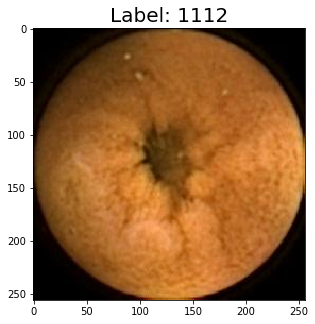


The 20 most similar images:


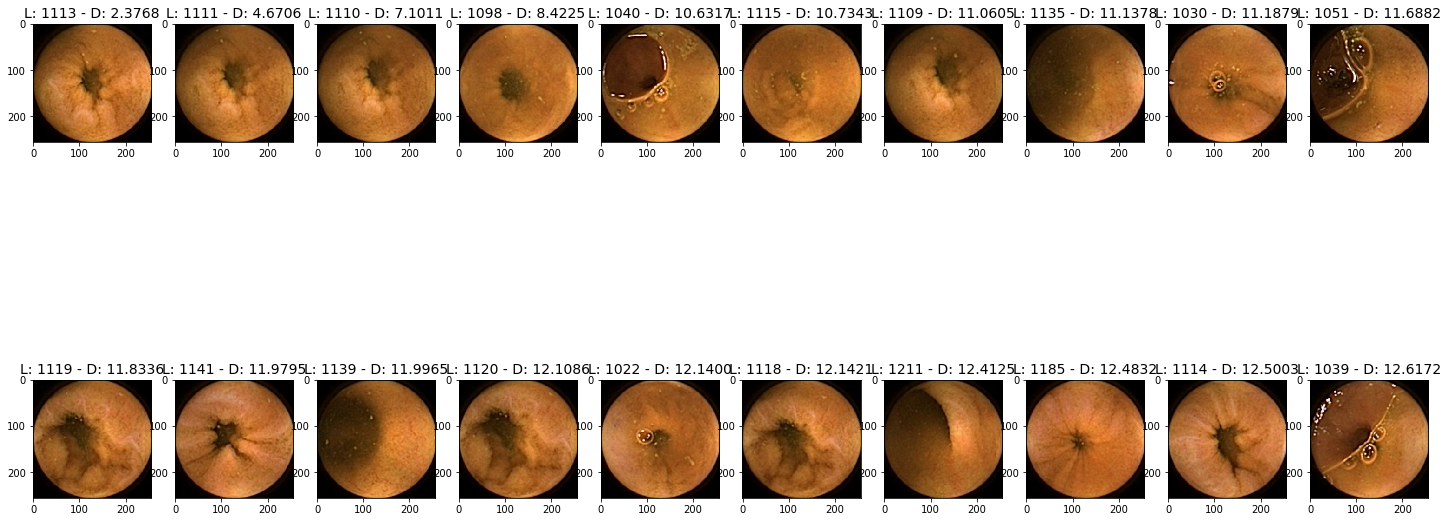


The 20 least similar images:


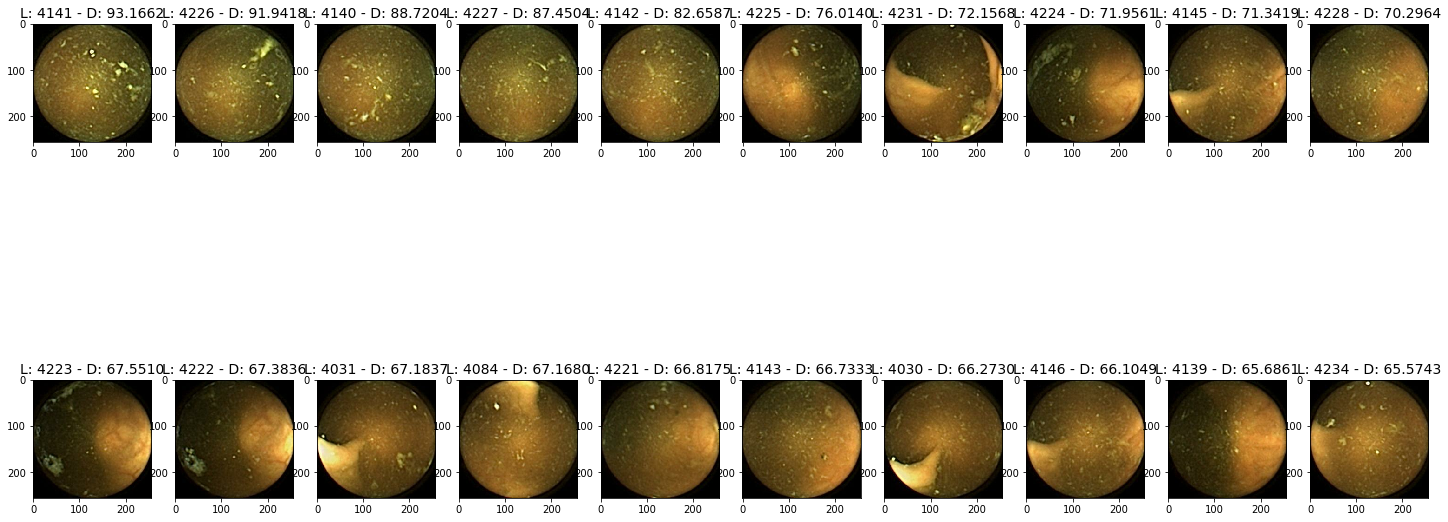

In [0]:
show_KNN(test_images, test_emb_dist, 1112, 2, 10, figsize=25)

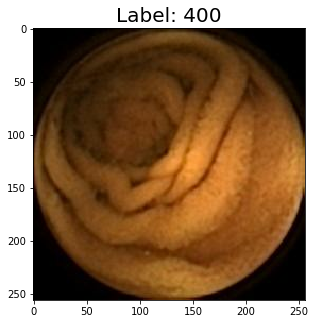


The 20 most similar images:


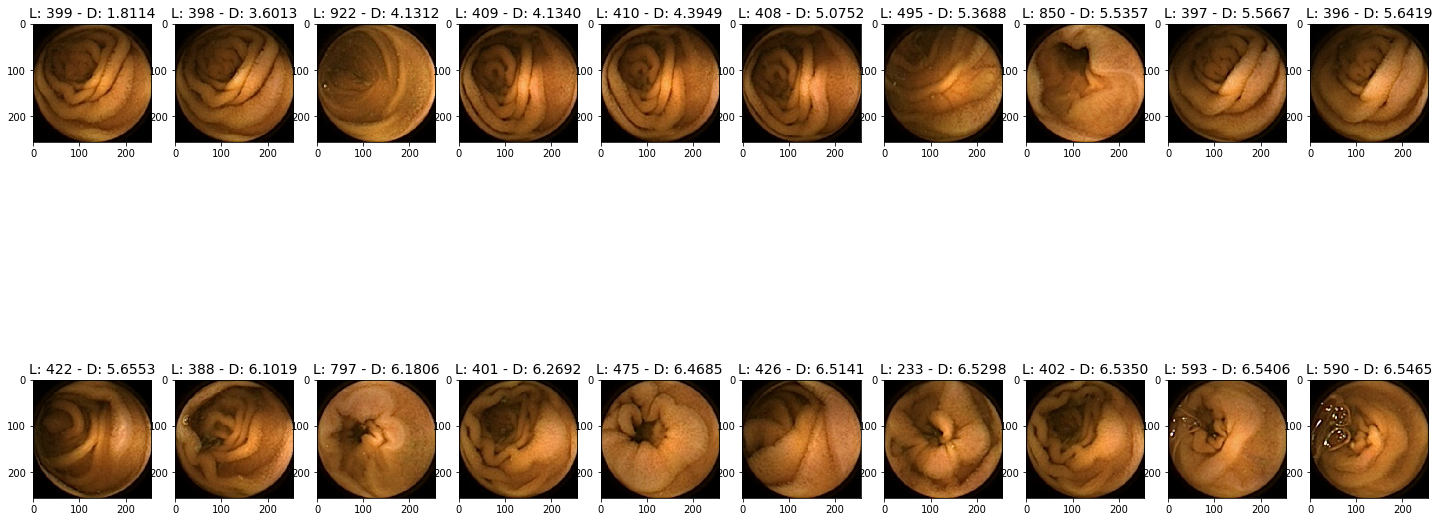


The 20 least similar images:


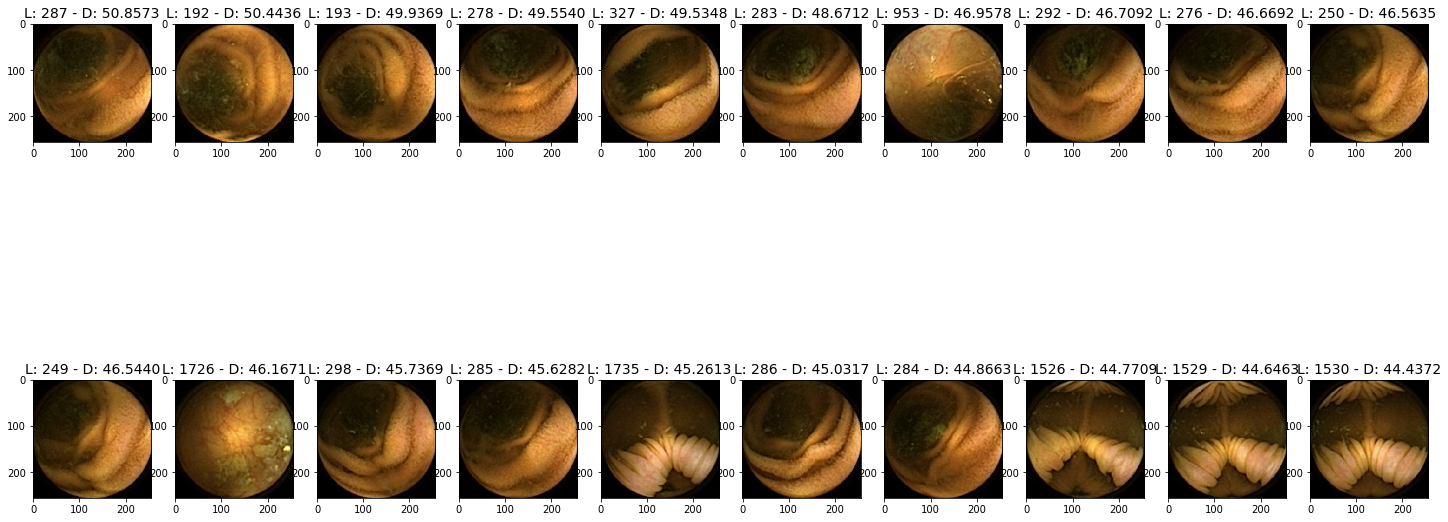

In [0]:
show_KNN(train_images, train_emb_dist, 400, 2, 10, figsize=25)

In [0]:
%%time
test_knn_score = simple_KNN_score(test_emb_dist, images_set=test_images, fracc=1.0)
print("KNN test accuracy:", 100*test_knn_score[0])
print("Mean distance of all the most similar frames:", test_knn_score[1])

Score based on the 8 most similar frames for a given frame
KNN test accuracy: 13.766666666666666
Mean distance of all the most similar frames: 5.434296068827311
CPU times: user 543 ms, sys: 2.53 ms, total: 546 ms
Wall time: 649 ms


In [0]:
%%time
train_knn_score = simple_KNN_score(train_emb_dist, images_set=train_images, fracc=1.0)
print("KNN train accuracy:", 100*train_knn_score[0])
print("Mean distance of all the most similar frames:",train_knn_score[1])

Score based on the 8 most similar frames for a given frame
KNN train accuracy: 22.858333333333334
Mean distance of all the most similar frames: 6.146451041062673
CPU times: user 482 ms, sys: 1.19 ms, total: 483 ms
Wall time: 485 ms


# RANK SCORE CALLS

Using 1500 elements out of 1500 for computing the rank scores
All test rank scores: [31.2, 40.53333333333333, 47.8, 52.6, 56.2, 59.266666666666666, 62.53333333333333, 64.93333333333334]
CPU times: user 3.76 s, sys: 0 ns, total: 3.76 s
Wall time: 3.77 s


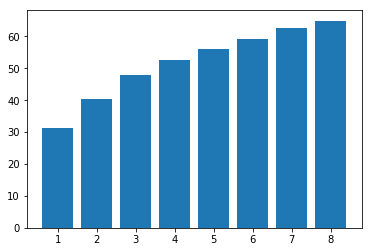

In [0]:
%%time
N = 2*label_frames_tolerance
rank_scores = rank_score_upto_n(N, test_emb_dist, images_set=test_images, fracc=1.0)
rank_scores = [score*100 for score in rank_scores]

plt.bar(range(1, N+1), rank_scores)
plt.plot()

print("All test rank scores:", rank_scores)
'''
for i in range(len(rank_scores)):
    print("Rank", i+1, "test score:", rank_scores[i]*100, "%")
'''

Using 1500 elements out of 1500 for computing the rank scores
All train rank scores: [52.0, 61.66666666666667, 66.33333333333333, 68.93333333333334, 70.8, 72.8, 74.06666666666666, 75.26666666666667]
CPU times: user 3.75 s, sys: 8.17 ms, total: 3.76 s
Wall time: 3.75 s


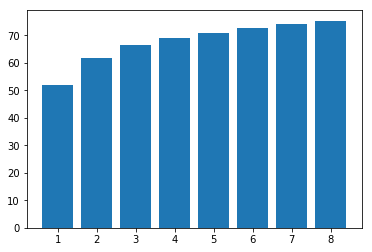

In [0]:
%%time
N = 2*label_frames_tolerance
rank_scores = rank_score_upto_n(N, train_emb_dist, images_set=train_images, fracc=1.0)
rank_scores = [score*100 for score in rank_scores]

plt.bar(range(1, N+1), rank_scores)
plt.plot()

print("All train rank scores:", rank_scores)
'''
for i in range(len(rank_scores)):
    print("Rank", i+1, "train score:", rank_scores[i]*100, "%")
'''

# VISUALIZE WEIGHTS

model/block_1/conv2d/kernel/Adam_1 (16, 16, 3, 10)
Kernels of the 1 layer


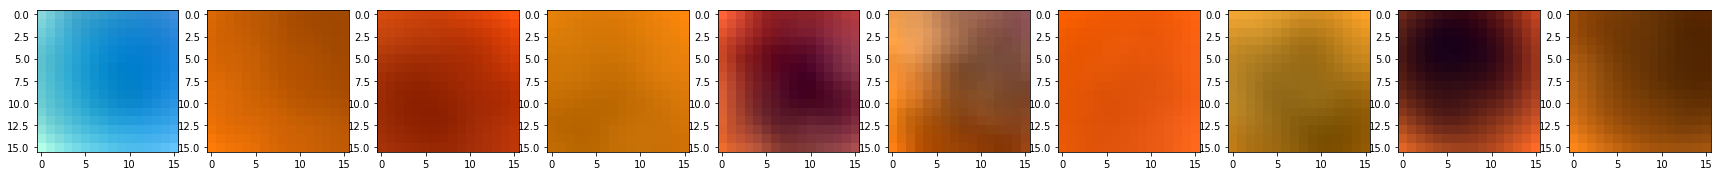

model/block_2/conv2d/kernel/Adam_1 (12, 12, 10, 10)
Kernels of the 2 layer


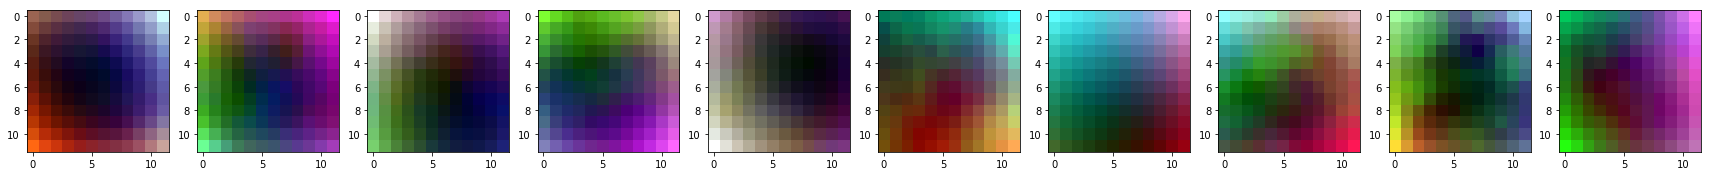

model/block_3/conv2d/kernel/Adam_1 (8, 8, 10, 20)
Kernels of the 3 layer


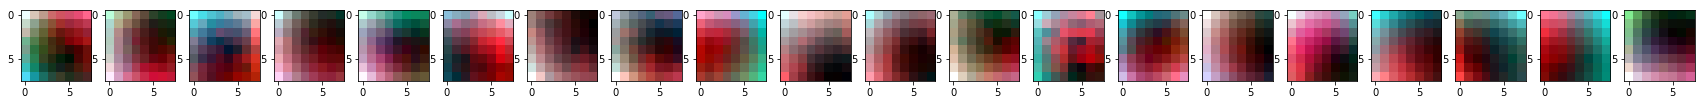

model/block_4/conv2d/kernel/Adam_1 (6, 6, 20, 20)
Kernels of the 4 layer


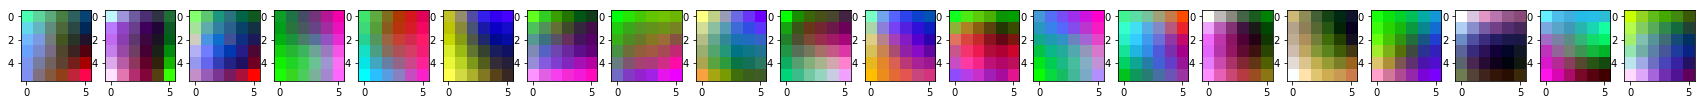

model/fc_1/dense/kernel/Adam_1 (1620, 24)
Trainable params of the 1 FC layer: (1620, 24)
Means of the FC layer


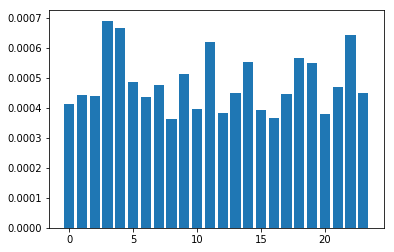

In [0]:
conv_layer = 1
fc_layer = 1
for var_name in estimator.get_variable_names():
    if 'kernel' not in var_name or 'Adam_1' not in var_name: continue
    variables = estimator.get_variable_value(var_name)
    print(var_name, variables.shape)
        
    if 'block_' in var_name:
        f, axarr = plt.subplots(ncols=variables.shape[3], nrows=1, figsize=(30, 25))
        for i in range(variables.shape[3]):
            filter = variables[:,:,:,i]
            filter -= filter.min()
            filter /= filter.max()
            if filter.shape[2] > 3:
                converted_image = spectral.get_rgb(filter)
                converted_image -= converted_image.min()
                converted_image /= converted_image.max()
                axarr[i].imshow(converted_image)
            else: axarr[i].imshow(filter)
        print('Kernels of the',conv_layer,'layer')
        plt.show()
        conv_layer += 1
        
    elif 'fc_' in var_name:
        print('Trainable params of the',fc_layer,'FC layer:', variables.shape)
        fc_layer += 1
        means = np.mean(variables, axis=0, dtype=np.float64)
        plt.bar(range(means.shape[0]), means)
        print('Means of the FC layer')
        plt.show()

# K-MEANS CLUSTERING

In [0]:
# COMPUTE THE K-MEANS CLUSTERING FOR TEST AND TRAIN EMBEDDINGS
%%time
test_clusters = 3
assert test_clusters <= 8, 'Maximum number of cluster to visualize is 8'
kmeans_test = KMeans(num_clusters, random_state=0).fit(np_test_embeddings)

test_clusters = kmeans_test.labels_
test_centers = kmeans_test.cluster_centers_

def cluster_to_color(cluster_label):
    if cluster_label == 0: return 'red'
    elif cluster_label == 1: return 'green'
    elif cluster_label == 2: return 'blue'
    elif cluster_label == 3: return 'c'
    elif cluster_label == 4: return 'm'
    elif cluster_label == 5: return 'y'
    elif cluster_label == 6: return 'k'
    elif cluster_label == 7: return 'w'

CPU times: user 90.6 ms, sys: 68.3 ms, total: 159 ms
Wall time: 92.6 ms


Test clusters by colour


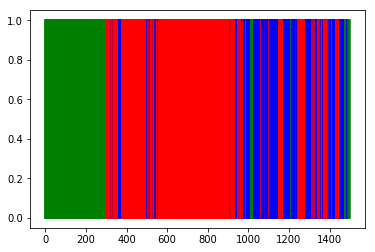

In [0]:
# VISUALIZE THE CLUSTERS
x = 0
for label in test_clusters:
    plt.plot([x, x], [0, 1], color=cluster_to_color(label))
    x += 1
print('Test clusters by colour')
plt.show()